In [29]:
#Refer Transfer Learning with Data Augmentation notebook before this one.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
import sys, os
from glob import glob 

import tensorflow as tf 
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model    
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
#Dataset from: https://mmspg.epfl.ch/downloads/food-image-datasets/
#Move corresponding images(0*.jpg and 1*.jpg) to data/train/nonfood and data/train/food respectively(similarly repeat for data/test).
train_path = 'data/train/'
valid_path = 'data/test/'

In [14]:
#Resize all images to a smaller size:
IMAGE_SIZE = [200, 200]

In [15]:
#glob returns all matching file paths.
#We find number of samples this way.
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [16]:
#We find number of classes this way.
folders = glob(train_path + '/*')

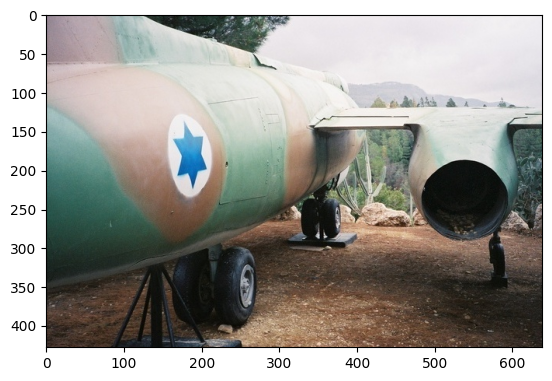

In [17]:
#Check to see if everything works.
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [18]:
ptm = PretrainedModel(
    input_shape = IMAGE_SIZE + [3], #for the colour channel
    weights = 'imagenet', #import weights trained on the imagenet dataset(by default, weights are initialised randomly for us to train)
    include_top = False #None of the final flatten/dense layers(only upto last convolution layer)
)
x = Flatten()(ptm.output)
#We don't require the dense layer as we are simply converting all images to feature vectors before training the head.

In [19]:
model = Model(inputs = ptm.input, outputs = x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [20]:
#We do not perform any augmentation, hence we can preemptively output all feature vectors prior to training.
gen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [21]:
batch_size = 128
#create training and validation generators
train_generator = gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    class_mode = 'binary' #Since we know our targets are binary, we do not need to one-hot encode them(which it does by default), this returns a 1-D array of classes(0/1)
)
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    class_mode = 'binary'
) 

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
#Prepare the dataset of feature vectors
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

sample_output = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = sample_output.shape[1]
X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_valid = np.zeros((Nvalid, D))
Y_valid = np.zeros(Nvalid)

1/1 [==============================] - 5s 5s/step


In [23]:
#Populate X_train and Y_train
i = 0
for x, y in train_generator: #x gives current batch of images, y gives their corresponding class labels
    feature_vectors = model.predict(x)
    batch_length = len(y) #Size of last batch is remainder
    X_train[i : i + batch_length] = feature_vectors
    Y_train[i : i + batch_length] = y
    i += batch_length
    if i >= Ntrain:
        print("X_train, Y_train Populated.")
        break
    print("Images Procesed: ", i)

4/4 [==============================] - 5s 65ms/step
Images Procesed:  128
4/4 [==============================] - 0s 92ms/step
Images Procesed:  256
4/4 [==============================] - 0s 92ms/step
Images Procesed:  384
4/4 [==============================] - 0s 92ms/step
Images Procesed:  512
4/4 [==============================] - 0s 92ms/step
Images Procesed:  640
4/4 [==============================] - 0s 93ms/step
Images Procesed:  768
4/4 [==============================] - 0s 92ms/step
Images Procesed:  896
4/4 [==============================] - 0s 92ms/step
Images Procesed:  1024
4/4 [==============================] - 0s 92ms/step
Images Procesed:  1152
4/4 [==============================] - 0s 92ms/step
Images Procesed:  1280
4/4 [==============================] - 0s 93ms/step
Images Procesed:  1408
4/4 [==============================] - 0s 93ms/step
Images Procesed:  1536
4/4 [==============================] - 0s 93ms/step
Images Procesed:  1664
4/4 [===========================

In [24]:
#Populate X_valid and Y_valid
i = 0
for x, y in valid_generator:
    feature_vectors = model.predict(x)
    batch_length = len(y)
    X_valid[i : i + batch_length] = feature_vectors
    Y_valid[i : i + batch_length] = y
    i += batch_length
    if i >= Nvalid:
        print("X_valid, Y_valid populated.")
        break
    print("Images Processed: ", i)

4/4 [==============================] - 0s 93ms/step
Images Processed:  128
4/4 [==============================] - 0s 94ms/step
Images Processed:  256
4/4 [==============================] - 0s 94ms/step
Images Processed:  384
4/4 [==============================] - 0s 94ms/step
Images Processed:  512
4/4 [==============================] - 0s 94ms/step
Images Processed:  640
4/4 [==============================] - 0s 94ms/step
Images Processed:  768
4/4 [==============================] - 0s 94ms/step
Images Processed:  896
4/4 [==============================] - 2s 663ms/step
X_valid, Y_valid populated.


In [27]:
print("Range of feature vectors: (", X_train.max(), ", ", X_train.min(), ')')

Range of feature vectors: ( 641.5079956054688 ,  0.0 )


In [30]:
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

In [31]:
#Trying out built-in logistic regression from scikit-learn
from sklearn.linear_model import LogisticRegression
built_in = LogisticRegression()
built_in.fit(X_train2, Y_train)
print(built_in.score(X_train2, Y_train))
print(built_in.score(X_valid2, Y_valid))

1.0
0.979


In [36]:
#Logistic regression in tensorflow
i = Input(shape = (D, ))
x = Dense(1, activation = 'sigmoid')(i) #We can use sigmoid since no one-hot encoding was done

linearmodel = Model(i, x)
linearmodel.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)
r = linearmodel.fit(
    X_train2, Y_train,
    batch_size = 128,
    epochs = 10,
    validation_data = (X_valid2, Y_valid)
) 

Epoch 1/10
24/24 [==============================] - 1s 21ms/step - loss: 0.1395 - accuracy: 0.9437 - val_loss: 0.0486 - val_accuracy: 0.9800
Epoch 2/10
24/24 [==============================] - 0s 13ms/step - loss: 0.0092 - accuracy: 0.9977 - val_loss: 0.0460 - val_accuracy: 0.9800
Epoch 3/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0443 - val_accuracy: 0.9810
Epoch 4/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0437 - val_accuracy: 0.9810
Epoch 5/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0435 - val_accuracy: 0.9810
Epoch 6/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9820
Epoch 7/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0428 - val_accuracy: 0.9810
Epoch 8/10
24/24 

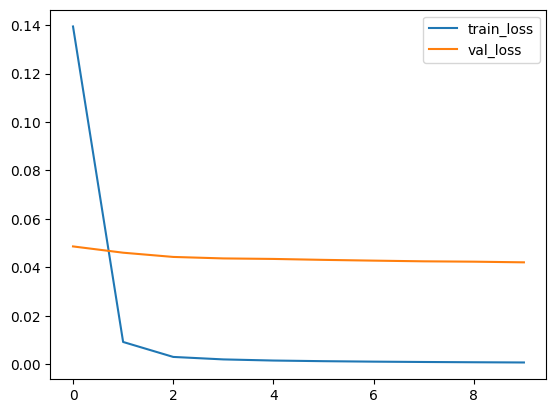

In [37]:
plt.plot(r.history['loss'], label = 'train_loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

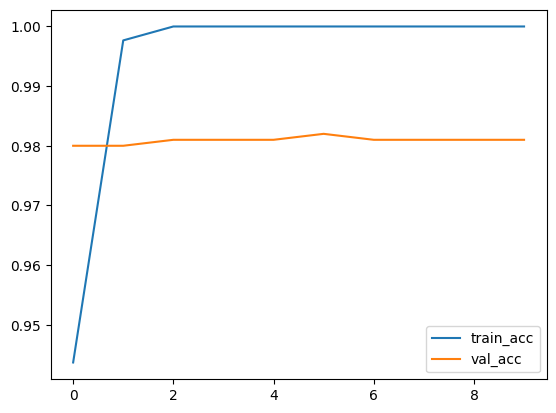

In [38]:
plt.plot(r.history['accuracy'], label = 'train_acc')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show()

## Observations in comparison to Data Augmented Transfer Learning:
#### -We get improved training and validation accuracy.
#### -Training is a lot faster.
#### -Model requires even lesser epochs to converge(about 2-3).